# Introduction 📜

 With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, I will use them to predict the final house price
 
 there is a file contains data describtion <span style="color:blue">data_describtion.txt</span>
 
 the dataset consists of 1460 rows and 79 columns

# Libraries 📚

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge, RidgeCV

from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBRegressor, XGBRFRegressor
import matplotlib.pyplot as plt

# Importing Data 📥

In [2]:
train_path = './data/train.csv'
test_path = './data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
y = train_df['SalePrice']
Ids = test_df['Id']

# Data Exploration 🔍

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Findings 📋

we can see some columns have null values BUT:
* if we reed the data describtion, we will realize that Alley has NA as a real value indicating *No Alley Access* so we should take care and **DON'T** drop it.
* same for FireplaceQu, NA means no Fireplace, so it's **NOT** a missing value so we need to keep it.
* same for Fence, NA means no Fence, it's **NOT** a mising value.
* same for PoolQC, NA means no pool , it's **NOT** a missing value.
* same for MiscFeature, NA means no Miscellaneous features not covered, it's **NOT** a missing value.
* same for ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] , NA means no Basement, it's **NOT** a missing value.
* same for ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], NA means no Garage, it's **NOT** a missing value.

but for [<span style = "color: green">'LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical','GarageYrBlt'</span>], these columns have missing values so we need to invistigate them further.

for <span style = "color:green">YearBuilt</span> and <span style = "color:green">YearRemodAdd</span>, they should be the same unless a remodeling has been done
so we can have a new feature **Remodeled** with **0** for no remodeling or addition and **1** for remodling or addition

## Univariant Exploration 📊

**Numerical Variables**

In [4]:
###  numerical variables
num_var = [col for col in train_df.columns if train_df[col].dtype != 'object']
print("Numerical Features are: \n")
print(num_var,"\n")

Numerical Features are: 

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 



In [5]:
def num_uni_graphs(features):
    '''
    This function takes features name and draw a figure containing a graph for each feature
    visualizes its distribution
    '''
    fig = plt.figure(figsize=(18,20))

    for i in range(len(features)):
        plt.subplot(10,4,i+1)
        plt.hist(train_df[features[i]])
        plt.title(features[i])
        plt.xlabel("Value")
        plt.ylabel("Count")
    fig.tight_layout()

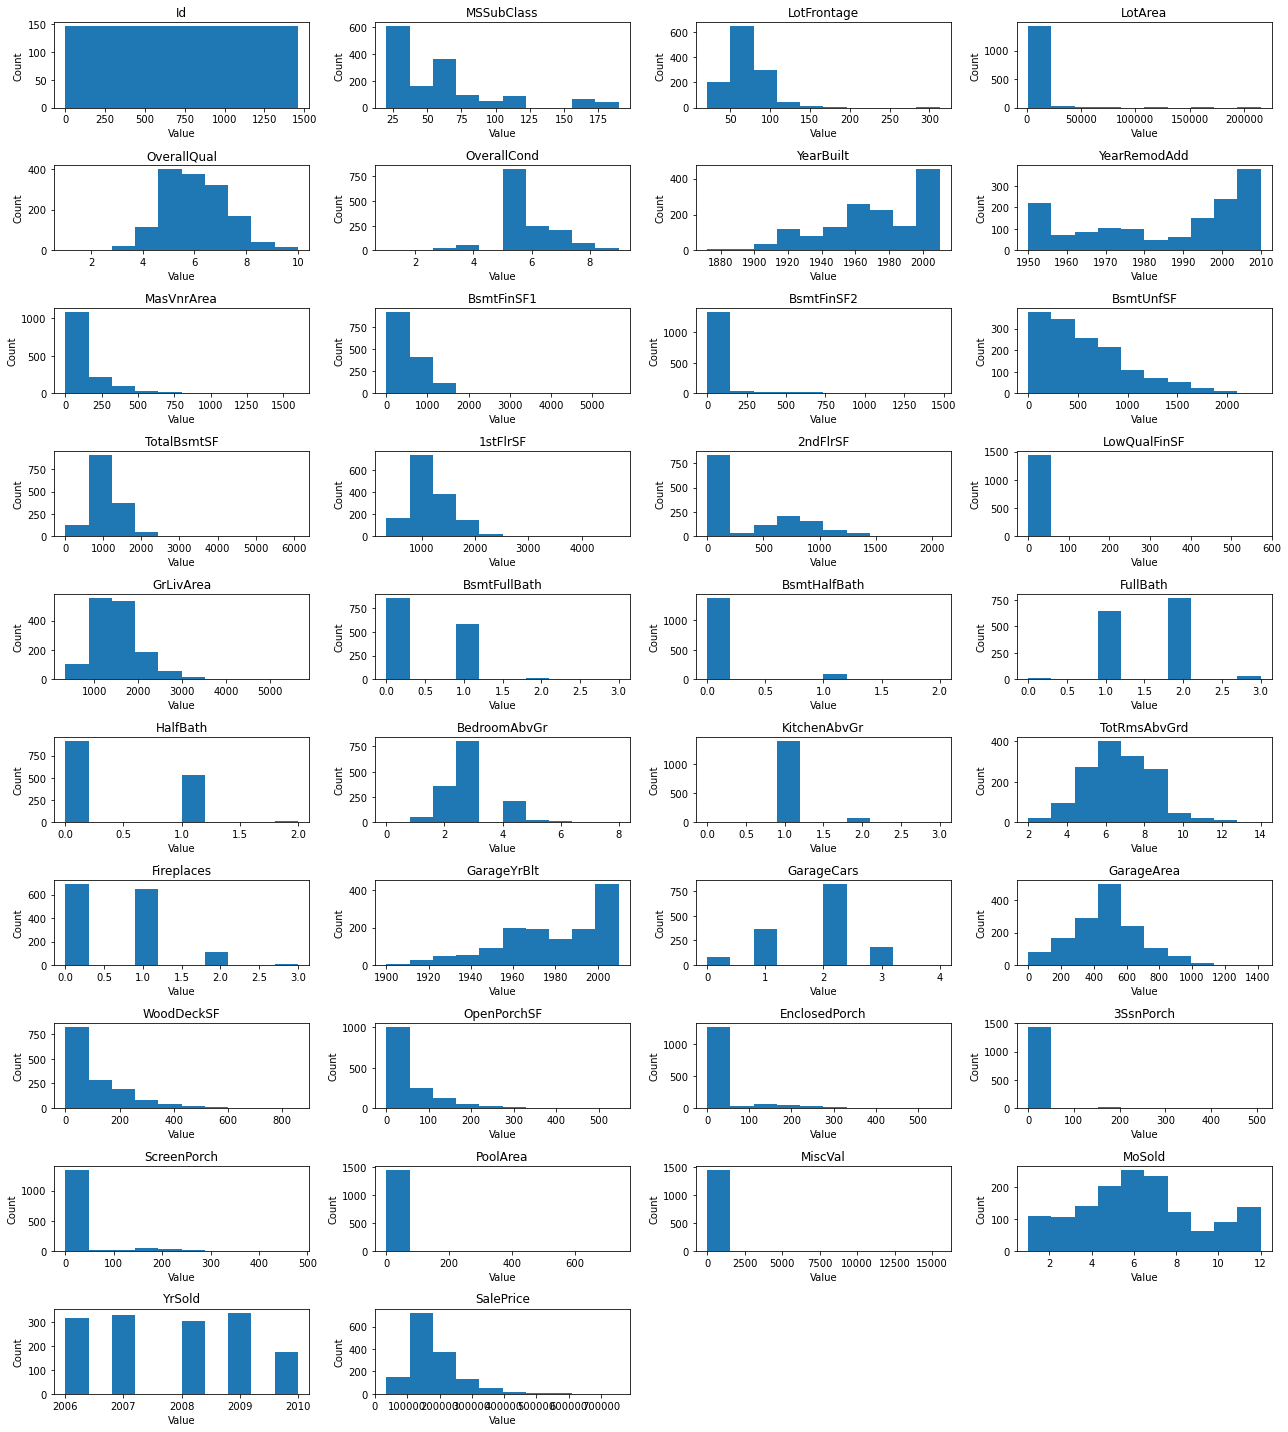

In [6]:
num_uni_graphs(num_var)

### Findings 📋

* from the graphs we can see some sparse columns like <span style ="color:blue">PoolArea</span>,<span style ="color:blue">LowQualFinSF</span>, <span style ="color:blue">MiscVal, 3SsnPorch</span> that would harm our model later, so it's better to drop them


* some features have skewed distribution, so we need to apply log to them, like [<span style = "color: green">'WoodDeckSF', 'OpenPorchSF', 'GrLivArea', '1stFlrSF, 'LotFrontage', 'MasVnrArea', 'BsmntFinSF1', 'BsmntUnfSF', 'TotalBsmntSF'</span>]

* for columns <span style = "color: green"> 3SsnPorch, ScreenPorch</span> they are almost sparse, but we can handle this in another way
    we can derive another column <span style = "color: blue">HasPorch</span> to indicate whether the house has Porch or not, and drop the old columns in order not to harm our model.
    
* for <span style = "color:green">LotArea</span> we can see there are many zeros, and that doesn't make sense because if lot area is 0 then no house exists
we can replace these zeros with mean for each lot grouped by the lot shape

In [7]:
###  HasPorch New Feature

train_df['HasPorch'] = 0
train_df.loc[((train_df['3SsnPorch']>0) | (train_df['ScreenPorch']>0)),'HasPorch'] = 1
print(train_df['HasPorch'].value_counts())

test_df['HasPorch'] = 0
test_df.loc[((test_df['3SsnPorch']>0)|(test_df['ScreenPorch']>0)),'HasPorch'] = 1

0    1320
1     140
Name: HasPorch, dtype: int64


In [8]:
###  Drop the two columns

train_df.drop(['3SsnPorch', 'ScreenPorch'], axis = 1, inplace = True)
test_df.drop(['3SsnPorch', 'ScreenPorch'], axis = 1, inplace = True)

In [9]:
###  calculate average area of each lot shape

means = train_df.groupby('LotShape')['LotArea'].mean()
means

LotShape
IR1    11894.545455
IR2    23733.658537
IR3    41338.200000
Reg     8876.915676
Name: LotArea, dtype: float64

In [10]:
###  we set the zeros to the average area associated with its lot shape

for shape, mean in zip(means.index,means):
    train_df.loc[((train_df['LotShape']==shape) & (train_df['LotArea']==0)), 'LotArea'] = mean
    test_df.loc[((test_df['LotShape']==shape)&(test_df['LotArea']==0)),'LotArea'] = mean

In [11]:
### Adding new Feature Remodeled

train_df['remodeled'] = 0
train_df.loc[(train_df['YearBuilt']!= train_df['YearRemodAdd']), 'remodeled'] = 1

test_df['remodeled'] = 0
test_df.loc[(test_df['YearBuilt']!= test_df['YearRemodAdd']), 'remodeled'] = 1

In [12]:
###  Drop YearBuilt, YearRemodBuilt
###   Reason: according to the describtion, these columns would have the same valus unless the house has been remodeled
###           So it's better to derieve another feature *Remodeled* as we did earlier and DROP these two columns.

train_df.drop('YearBuilt', axis = 1, inplace = True)
test_df.drop('YearBuilt', axis = 1, inplace = True)

train_df.drop('YearRemodAdd', axis = 1, inplace = True)
test_df.drop('YearRemodAdd', axis = 1, inplace = True)


In [13]:
def apply_log(*cols):
    '''
    This function takes multiple inputs and iterate on them, each value should be a column name in the dataframe
    it applies log function to that column values excpet zeros to avoid raising errors
    
    '''
    
    for col in cols:
        train_df.loc[train_df[col]>0,col] = pd.Series(np.log(train_df.loc[train_df[col]>0,col]))

        test_df.loc[test_df[col]>0,col] = pd.Series(np.log(test_df.loc[test_df[col]>0,col]))


In [14]:
###   Apply Log to numerical Features with skewed distribution


apply_log('WoodDeckSF', 'OpenPorchSF', 'GrLivArea', '1stFlrSF', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF')

In [15]:
columns_to_drop = ['PoolArea', 'LowQualFinSF', 'MiscVal']

In [16]:
###    Drop sparse columns


train_df.drop(columns_to_drop, axis = 1, inplace = True)
test_df.drop(columns_to_drop, axis = 1, inplace = True)

### update our numerical variable list after deleting some of them
num_var = [col for col in train_df.columns if train_df[col].dtype != 'object']

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasPorch,remodeled
0,1,60,RL,4.174387,8450.0,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,2,2008,WD,Normal,208500,0,0
1,2,20,RL,4.382027,9600.0,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,5,2007,WD,Normal,181500,0,0
2,3,60,RL,4.219508,11250.0,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,9,2008,WD,Normal,223500,0,1
3,4,70,RL,4.094345,9550.0,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,2,2006,WD,Abnorml,140000,0,1
4,5,60,RL,4.430817,14260.0,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,12,2008,WD,Normal,250000,0,0


**Categorical Variables**

In [17]:
###  Categorical Variables


cat_var = [col for col in train_df.columns if train_df[col].dtype == 'object']
print("Categorical Features are: \n")
print(cat_var)

Categorical Features are: 

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [18]:
def cat_uni_graphs(features):
    '''
    This function takes features name and draw a figure containing a graph for each feature
    visualizes its values count
    '''
    fig = plt.figure(figsize=(18,20))
    for i in range(len(cat_var)):
        if i < 44:
            y = i
        else: y = 44
        plt.subplot(9,5,y+1)
        sns.barplot(x =train_df[cat_var[i]].value_counts().index,y =train_df[cat_var[i]].value_counts()).set_title(cat_var[i])
    fig.tight_layout()

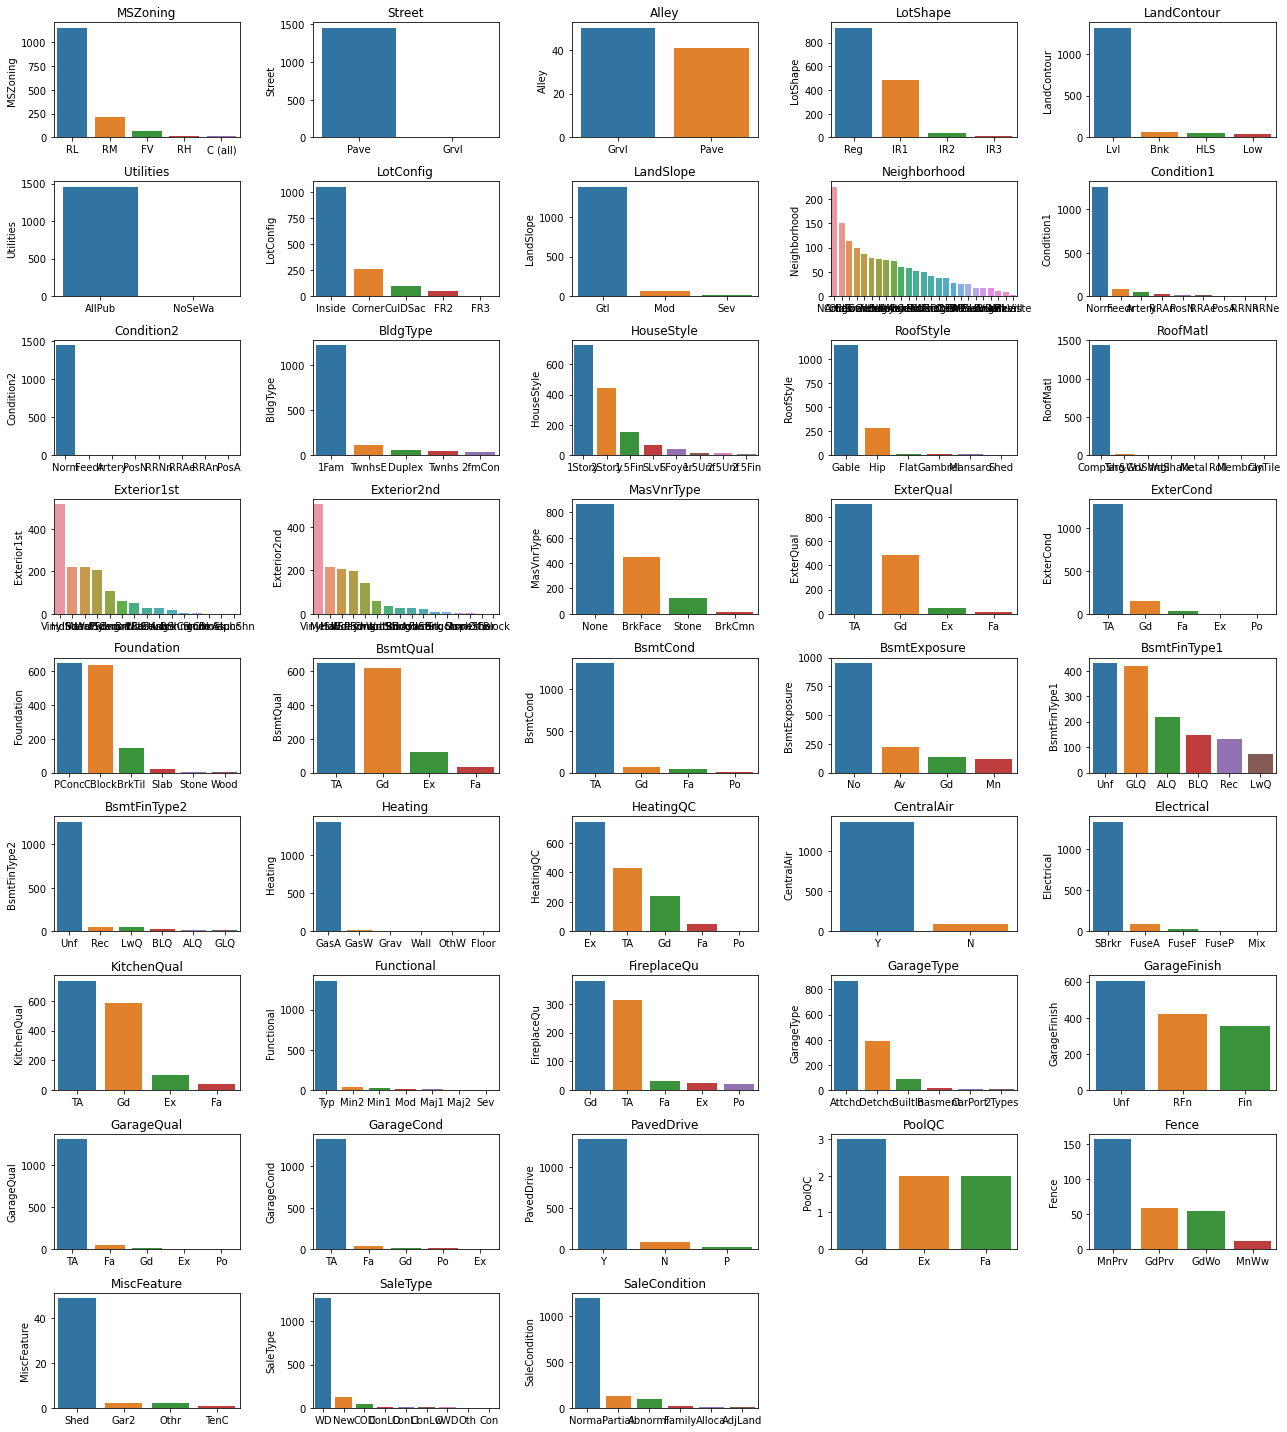

In [19]:
cat_uni_graphs(cat_var)

some categorical columns almost consist of one variable, that would harm our model, so it would be better to drop them and see

[<span style = "color: green">Street,Utilities,Condition2, RoofMatl, Heating</span>]

In [20]:
train_df.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis = 1, inplace = True)
test_df.drop(['Street', 'Utilities', 'Condition2','RoofMatl','Heating'], axis = 1, inplace = True)

## Bivariant Exploration 📈

In [21]:
###    pair-wise relations between numerical features and target 'SalePrice'
def num_Bi_graphs(features):
    fig = plt.figure(figsize=(18,20))
    for i in range(len(features)):
        if i < 44:
            y = i
        else: y = 44
        plt.subplot(10,5,y+1)
        sns.scatterplot(x =train_df[features[i]],y =train_df['SalePrice']).set_title(features[i])
    fig.tight_layout()

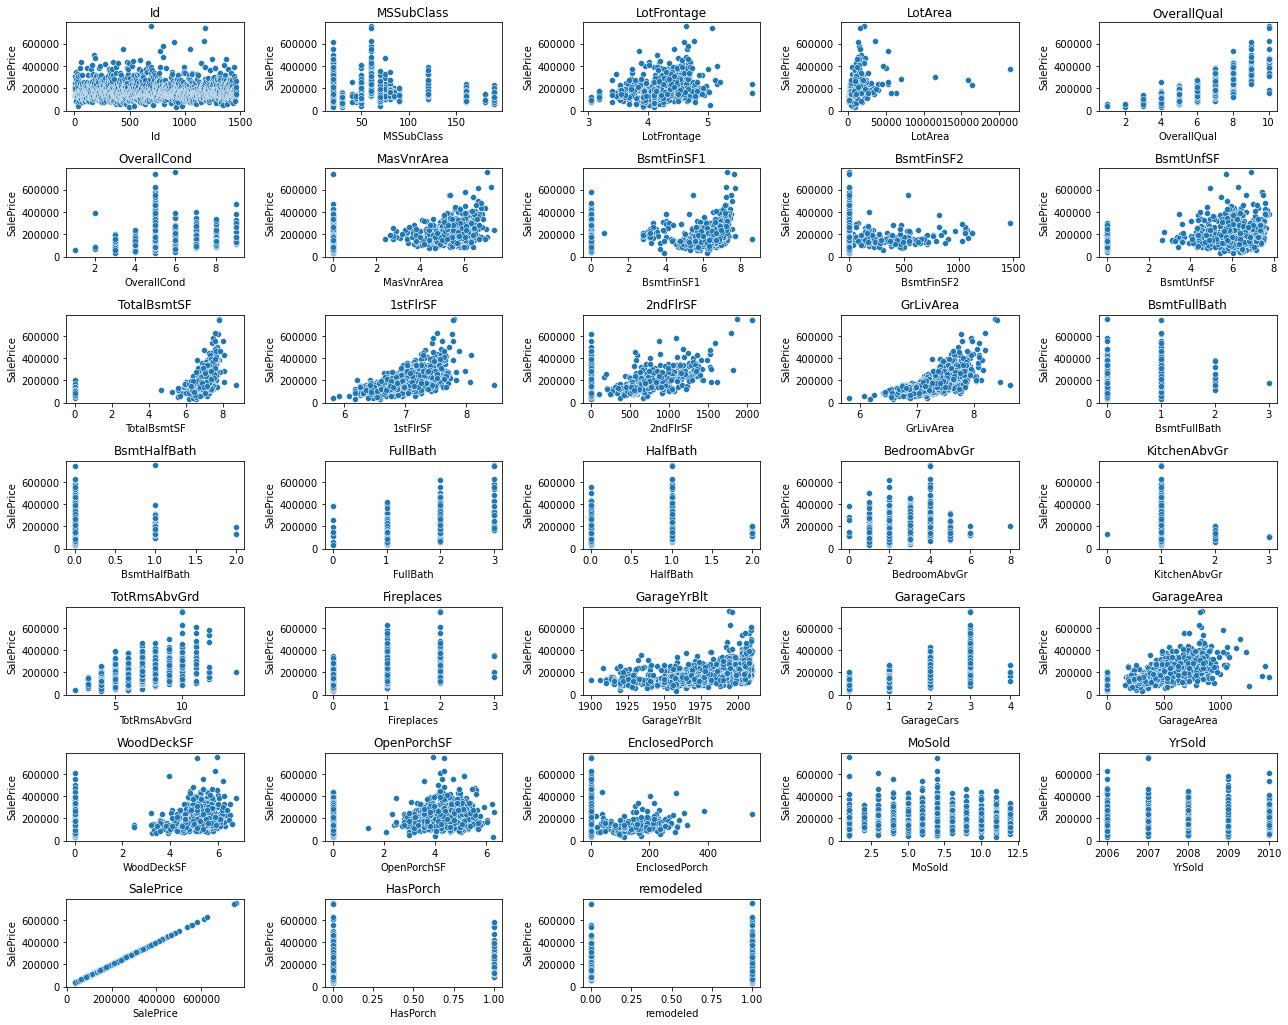

In [22]:
num_Bi_graphs(num_var)

In [23]:
###   From the graphs we can see that MoSold, YrSold Don't affect the salse Price So they are reduntant variables
#     it would be better if we drop them

train_df.drop('MoSold', axis = 1, inplace = True)
test_df.drop('MoSold', axis = 1, inplace = True)
train_df.drop('YrSold', axis = 1, inplace = True)
test_df.drop('YrSold', axis = 1, inplace = True)


## Data Cleaning 🚿

### Missing Values ❓

**Lot Frontage**

 Describtion: Linear Feet of street connected to property

for missing values in Lot Frontage we will put it = 0

In [24]:
train_df.loc[(train_df['LotFrontage'].isna()), 'LotFrontage'] = 0

**MasVnrType**

we got two columns about Masonry veneer, **MasVnrType** & **MasVnrArea** we need to check that the null values in both of them are in the same rows, if so we can make their area = 0

In [25]:
###  we fill missing values of MasVnrArea with zeros indicating that no MasVnr and by logical the area then should be 0
train_df.loc[train_df['MasVnrType'].isna() == True, 'MasVnrArea']= 0
###  we do the same for test datset
test_df.loc[test_df['MasVnrType'].isna() == True, 'MasVnrArea']= 0

In [26]:
train_df['MasVnrType'].isna().sum()

8

In [27]:
### we fill the missing values of MasVnrType with 'Stone'
train_df.loc[train_df['MasVnrType'].isna() == True, 'MasVnrType']= 'Stone'

### we do the same for test dataset
test_df.loc[test_df['MasVnrType'].isna() == True, 'MasVnrType']= 'Stone'

**Electrical**

there is a single row with missing value for this column so we can fill it with the most frequent value **SBrkr**

In [28]:
train_df[(train_df['Electrical'].isna()==True)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice,HasPorch,remodeled
1379,1380,80,RL,4.290459,9735.0,NaN,Reg,Lvl,Inside,Gtl,...,0.0,0,NaN,NaN,NaN,WD,Normal,167500,0,1


In [29]:
train_df.loc[train_df['Electrical'].isna()==True, 'Electrical'] = 'SBrkr'
test_df.loc[test_df['Electrical'].isna()==True, 'Electrical'] = 'SBrkr'

since **SBrkr** is the most frequent value, we can reconstruct this column to have values ['SBrkr', 'Not SBrkr'] to give weight to other values

In [30]:
train_df.loc[(train_df['Electrical'] != 'SBrkr'), 'Electrical']= 'Not SBrkr'
test_df.loc[(test_df['Electrical'] != 'SBrkr'), 'Electrical']= 'Not SBrkr'

**Garage**

same as MasVnrType, the rows with NA value for GarageType, have missing values in GarageYrBlt, so we can put their year value = 0

In [31]:
(train_df['GarageType'].isna() & train_df['GarageYrBlt'].isna()).sum()

81

In [32]:
train_df.loc[(train_df['GarageType'].isna() == True, 'GarageYrBlt')]= 0
test_df.loc[(test_df['GarageType'].isna() == True, 'GarageYrBlt')]= 0

In [33]:
train_df['GarageYrBlt'].isna().sum()

0

In [34]:
(train_df['GarageType'].isna() & train_df['GarageYrBlt'].isna()).sum()

0

<AxesSubplot:>

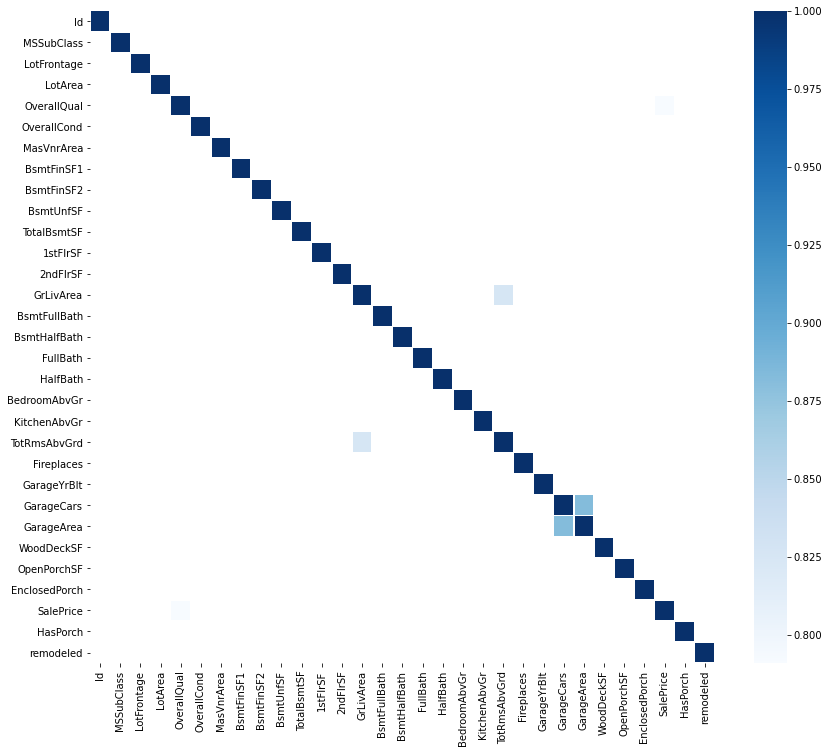

In [35]:
plt.figure(figsize=(14,12))
corr = train_df.corr()

sns.heatmap(corr, mask = corr <0.7, cmap = 'Blues', linewidth = 0.5)

we can see that <span style = "color:blue">GarageCars</span> and <span style = "color:blue">GarageArea</span> are correlated to each other, which would affect our model, so it would be better if we drop one of them

I chose to drop GarageCars since it's a categorical variable, and numerical variables are more beneficial for regression problems

In [36]:
corr[['SalePrice']].sort_values(['SalePrice'], ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.695118
GarageCars,0.640409
GarageArea,0.623431
1stFlrSF,0.591264
FullBath,0.560664
TotRmsAbvGrd,0.533723
Fireplaces,0.466929
OpenPorchSF,0.430243


## Data Encoding 📝

In [37]:
def encoding(data):
    '''
    this function take a dataframe as input and apply get_dummies on the categorical variables
    with drop_first = True, to get k-1 columns and avoid Multicollinearity problem
    
    '''
    data=pd.get_dummies(drop_first = True,data=data,columns=['MSSubClass'],prefix='MSSubClass')
    
    data=pd.get_dummies(drop_first=True,data=data,columns=['MSZoning'],prefix='MSZoning')
    data=pd.get_dummies(drop_first = True,data=data,columns=['Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','BldgType','HouseStyle'])
    data=pd.get_dummies(drop_first = True,data=data,columns=['OverallQual'],prefix='OverallQual')
    data=pd.get_dummies(drop_first = True,data=data,columns=['OverallCond'],prefix='OverallCond')
    data=pd.get_dummies(drop_first = True,data=data,columns=['RoofStyle','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition'])
    data=pd.get_dummies(drop_first = True,data=data,columns=['BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd'])

    return data

In [38]:
trainrow=train_df.shape[0]
testrow=test_df.shape[0]

In [39]:
### combining train and test data to ensure the encoding is the same for both datasets

data=pd.concat((train_df,test_df)).reset_index(drop=True)
data=data.drop(['SalePrice','Id','GarageCars'],1)

In [40]:
### for any missing data we haven't noticed, set = 0
data.fillna(0, inplace = True)

In [41]:
data = encoding(data)

## Model Building 🛠

In [42]:
###  get back our train , test datasets 

X_train=data.iloc[:trainrow]
X_test=data.iloc[trainrow:]

###  apply standard scaler on data to help in model fitting

scaler=StandardScaler()
scaler=scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [43]:
###  Model building, using StackingRegressor

xgblr = XGBRegressor(random_state = 0, max_depth = 15,n_estimators=200, eta = 0.2)
lr7 = XGBRFRegressor(random_state = 0, max_depth = 15,n_estimators=200, eta = 0.2)
lr6 = GradientBoostingRegressor(max_depth = 15, random_state = 0, loss = 'huber',n_estimators=200)
estimators = [
    ('xgbrfr', lr7),
    ('xgbreg', xgblr),
    ('histlr', lr6)
]
f = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

reg = StackingRegressor(estimators = estimators, final_estimator = f, cv = 5).fit(X_train, y)


## Prediction 🎯

In [44]:
### Predictions & Submit File

predictions = reg.predict(X_test)
outdata = {'Id': Ids, 'SalePrice': predictions}
output = pd.DataFrame(outdata)
output.to_csv('out.csv', index=False)

output.head()

,Id,SalePrice
0,1461,125827.336002
1,1462,154894.919609
2,1463,185696.220256
3,1464,182685.789453
4,1465,195141.697176
